In [2]:
import torch

In [3]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models

In [4]:
import cv2
from PIL import Image
import numpy as np

In [5]:
from pathlib import Path
import os

In [6]:
def process_img(image_path, output_size=(224, 224), save_path=None):
    """
    Process a single image: detect face, crop, and optionally save
    
    Args:
        image_path: Path to input image
        output_size: Tuple (width, height) for output size
        save_path: Optional path to save processed image
    
    Returns:
        PIL Image: Processed image
    """
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

    try:
        img = Image.open(image_path).convert('RGB')
        img_np = np.array(img)
        gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)

        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

        if len(faces) > 0:
            largest_face = max(faces, key=lambda x: x[2] * x[3])
            x, y, w, h = largest_face

            padding = int(max(w, h) * 0.1)

            x = max(0, x - padding)
            y = max(0, y - padding)
            w = min(img_np.shape[1] - x, w + 2 * padding)
            h = min(img_np.shape[0] - y, h + 2 * padding)

            face_crop = img_np[y:y+h, x:x+w]
            processed_img = Image.fromarray(face_crop)
        else:
            width, height = img.size
            size = min(width, height)
            left = (width - size) // 2
            top = (height - size) // 2
            processed_img = img.crop((left, top, left + size, top + size))
        
        processed_img = processed_img.resize(output_size, Image.Resampling.LANCZOS)
        
        if save_path:
            processed_img.save(save_path, quality=95)
            
        return processed_img
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None


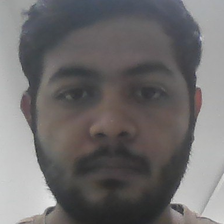

In [7]:
process_img("./test_input_img_not_drowsy.jpg", (224, 224))

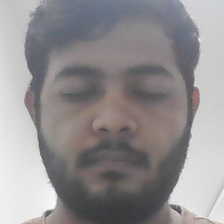

In [8]:
process_img("./test_input_img_drowsy.jpg", (224, 224))

In [9]:
def create_processed_dataset(source_dir, target_dir, output_size=(224, 224)):
    """
    Create processed dataset by looping over all images in source directory
    
    Args:
        source_dir: Path to original dataset
        target_dir: Path to save processed dataset
        output_size: Tuple (width, height) for processed images
    
    Returns:
        tuple: (processed_count, failed_count)
    """

    Path(target_dir).mkdir(exist_ok=True)

    processed_count = 0
    failed_count = 0

    for class_name in os.listdir(source_dir):
        class_path = os.path.join(source_dir, class_name)
        
        if not os.path.isdir(class_path):
            continue
            
        target_class_path = os.path.join(target_dir, class_name)
        Path(target_class_path).mkdir(exist_ok=True)
        
        print(f"Processing class: {class_name}")
        
        for img_filename in os.listdir(class_path):
            if not img_filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                continue
                
            img_path = os.path.join(class_path, img_filename)
            target_path = os.path.join(target_class_path, img_filename)
            
            if os.path.exists(target_path):
                processed_count += 1
                continue
            
            processed_img = process_img(img_path, output_size, target_path)
            
            if processed_img is not None:
                processed_count += 1
            else:
                failed_count += 1
        
        print(f"Completed {class_name}: {processed_count} total processed")
    
    print(f"Dataset processing complete!")
    print(f"Total processed: {processed_count}")
    print(f"Total failed: {failed_count}")
    
    return processed_count, failed_count

In [ ]:
# !ALERT: Needed only once
create_processed_dataset("./dataset", "./processed_dataset", output_size=(224, 224))

Processing class: drowsy
Completed drowsy: 22348 total processed
Processing class: non_drowsy
Completed non_drowsy: 41793 total processed
Dataset processing complete!
Total processed: 41793
Total failed: 0


(41793, 0)

In [11]:
def compute_dataset_stats(dataset_path):
    """
    Compute mean and std from processed dataset
    """
    transform = transforms.Compose([transforms.ToTensor()])
    dataset = datasets.ImageFolder(dataset_path, transform=transform)
    loader = DataLoader(dataset, batch_size=64, shuffle=False)
    
    mean = torch.zeros(3)
    std = torch.zeros(3)
    total_samples = 0
    
    for data, _ in loader:
        batch_samples = data.size(0)
        data = data.view(batch_samples, data.size(1), -1)
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)
        total_samples += batch_samples
    
    mean /= total_samples
    std /= total_samples
    
    return mean, std

In [12]:
mean, std = compute_dataset_stats("./processed_dataset")

In [13]:
print("mean =", mean)
print("std =", std)

mean = tensor([0.5010, 0.3806, 0.3363])
std = tensor([0.2296, 0.2051, 0.1889])


In [14]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [15]:
def test_train_split(dataset_path):
    full_dataset = datasets.ImageFolder(dataset_path, transform=train_transform)

    train_size = int(0.8 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

    test_dataset.dataset.transform = test_transform

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    return train_loader, test_loader

In [16]:
train_loader, test_loader = test_train_split("./processed_dataset")

In [17]:
class CNN(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.features = nn.Sequential(
            # First conv block
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            # Second conv block
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            # Third conv block
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            # Fourth conv block
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            # Global average pooling
            nn.AdaptiveAvgPool2d((1, 1))
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [43]:
def predict_single_image(model, image_path, mean, std, device, class_names=['awake', 'drowsy']):
    """
    Predict drowsiness for a single image
    
    Args:
        model: Trained CNN model
        image_path: Path to image file
        mean: Dataset mean for normalization
        std: Dataset std for normalization
        device: torch device
        class_names: List of class names
    
    Returns:
        tuple: (predicted_class, confidence)
    """
    # Process the image
    processed_img = process_img(image_path)
    if processed_img is None:
        return None, 0.0
    
    # Create transform
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])
    
    # Apply transform and add batch dimension
    img_tensor = transform(processed_img).unsqueeze(0).to(device)
    
    # Predict
    model.eval()
    with torch.no_grad():
        outputs = model(img_tensor)
        probabilities = torch.softmax(outputs, dim=1)
        confidence, predicted = torch.max(probabilities, 1)
        
        predicted_class = class_names[predicted.item()]
        confidence_score = confidence.item()
    
    return predicted_class, confidence_score

In [19]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * imgs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    return running_loss / total, correct / total

In [20]:
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * imgs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    return running_loss / total, correct / total

In [35]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=10):
    model.to(device)
    best_val_acc = 0.0
    
    for epoch in range(epochs):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        print("-" * 50)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
    
    print(f"Best validation accuracy: {best_val_acc:.4f}")

In [36]:
def test_model(model, test_loader, criterion, device):
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    print(f"Test Loss: {test_loss:.4f}, Acc: {test_acc:.4f}")

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [38]:
model = CNN(num_classes=2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [39]:
print("Starting training...")
train_model(model, train_loader, test_loader, criterion, optimizer, device, epochs=1)

Starting training...
Epoch 1/1
Train Loss: 0.2006, Train Acc: 0.9250
Val Loss: 0.5810, Val Acc: 0.8117
--------------------------------------------------
Best validation accuracy: 0.8117


In [33]:
print("Starting testing...")
test_model(model, test_loader, criterion, device)

Starting testing...
Test Loss: 0.0910, Acc: 0.9748


In [44]:
predict_single_image(model, "./test_input_img_drowsy.jpg", mean, std, device)

('drowsy', 0.901897668838501)

In [46]:
predict_single_image(model, "./test_input_img_not_drowsy.jpg", mean, std, device)

('awake', 0.8688299655914307)